In [7]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append("..")

from fastai.tabular import FillMissing, Categorify, Normalize, TabularList, tabular_learner
from fastai.callbacks.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.basic_data import DatasetType
from torch.nn import CrossEntropyLoss as CEloss
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import src.train_utils as u

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)

u.random_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
train_path = '../data/train_1002.pkl'
test_path = '../data/test_1002.pkl'

train_full, test, all_cols, cont_cols, cat_cols = u.read_data(
    train_path=train_path, test_path=test_path)

In [6]:
data_bunch = u.create_fai_databunch(train=train_full, test=test,
                                    cat_cols=cat_cols, cont_cols=cont_cols)

## Model training

epoch,train_loss,valid_loss,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,f1,time
0,0.496972,0.272792,0.094213,02:28
1,0.165415,0.167490,0.121073,02:27
2,0.115463,0.168385,0.118739,02:27
3,0.106804,0.169820,0.119572,02:26
4,0.104509,0.170812,0.118957,02:27
5,0.102288,0.175328,0.106404,02:28


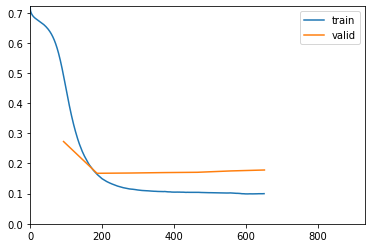

Better model found at epoch 0 with f1 value: 0.09421302767682416.
Better model found at epoch 1 with f1 value: 0.1210734810020644.
Epoch 6: early stopping


f1 score  0.1208 
 recall 0.1452 
 precision 0.1035 
 th  0.4211 
 events  pred 9509 
 events true 6776


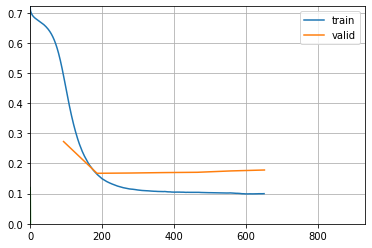

epoch,train_loss,valid_loss,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,f1,time
0,0.546779,0.293060,0.106112,02:28
1,0.172672,0.168190,0.114198,02:26
2,0.116457,0.171242,0.117654,02:27
3,0.107105,0.170060,0.115793,02:28
4,0.103858,0.174246,0.116442,02:26
5,0.102256,0.171249,0.115143,02:25
6,0.099227,0.179925,0.107923,02:26


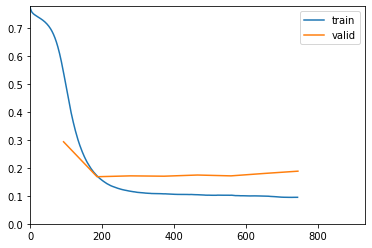

Better model found at epoch 0 with f1 value: 0.10611210323175298.
Better model found at epoch 1 with f1 value: 0.11419840416501613.
Better model found at epoch 2 with f1 value: 0.11765394521189416.
Epoch 7: early stopping


f1 score  0.1182 
 recall 0.1522 
 precision 0.0966 
 th  0.4737 
 events  pred 10672 
 events true 6776


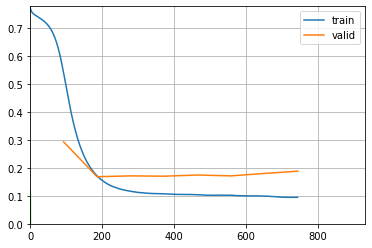

epoch,train_loss,valid_loss,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,f1,time
0,0.481595,0.250927,0.115157,02:28
1,0.162699,0.169439,0.118069,02:28
2,0.115150,0.167444,0.119309,02:27
3,0.106749,0.168422,0.114668,02:27
4,0.104294,0.171059,0.110555,02:28
5,0.101911,0.175936,0.108540,02:29


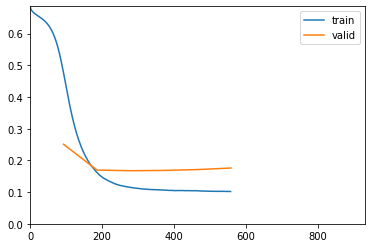

Better model found at epoch 0 with f1 value: 0.11515654648956357.
Better model found at epoch 1 with f1 value: 0.11806944658152538.
Better model found at epoch 2 with f1 value: 0.11930862869056427.


In [ ]:
n_attempts = 4

best_learn, best_score = None, 0

for i in tqdm(range(n_attempts)):
    learn = u.train_fai_model(data=data_bunch)
    _, score = u.estimate(learn, th_start=0, th_stop=1, steps=51)
    
    if score > best_score:
        best_learn = learn
        best_score = score
        del learn
        
    if best_score > 12.2:
        break


best_learn.save(f'best_model_{round(best_score, 6)}')

# Submit

In [ ]:
probas_test, *_ = best_learn.get_preds(DatasetType.Test)
probas_test = probas_test[:, 1]

n_pred = 8118
pred_test = np.zeros(len(test), bool)
pred_test[np.argsort(-1 * probas_test)[:8118]] = True


print(f'Predicted events: {pred_test}')

In [ ]:
submit = pd.DataFrame(
    data={'datetime x segment_id': test['datetime x segment_id'].values,
          'prediction': pred_test.astype(int)}
)
submit.to_csv(f'../results/submit_fai_{n_pred}.csv', index=False)